# Preprocessing of human cell atlas of fetal chromatin accessibility

We pre-process the cell atlas of fetal chromatin accessibility[[1]](https://www.science.org/doi/10.1126/science.aba7612). We use the `adata` object provided by Cao et al.[[2]](https://www.nature.com/articles/s41587-022-01284-4) in [GLUE](https://scglue.readthedocs.io/en/latest/data.html), [Domcke-2020.h5ad](http://download.gao-lab.org/GLUE/dataset/Domcke-2020.h5ad). 

[[1] Domcke, S., Hill, A.J., Daza, R.M., Cao, J., O’Day, D.R., Pliner, H.A., Aldinger, K.A., Pokholok, D., Zhang, F., Milbank, J.H. and Zager, M.A., 2020. A human cell atlas of fetal chromatin accessibility. Science, 370(6518), p.eaba7612.](https://www.science.org/doi/10.1126/science.aba7612)

[[2] Cao, Z.J. and Gao, G., 2022. Multi-omics single-cell data integration and regulatory inference with graph-linked embedding. Nature Biotechnology, 40(10), pp.1458-1466.](https://www.nature.com/articles/s41587-022-01284-4)

## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [3]:
import os
import sys

import scanpy as sc
from muon import atac as ac
import anndata
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/uma

In [4]:
sys.path.append("../../")
sys.path.append("../../utils/")
from paths import DATA_DIR, FIG_DIR

## set parameters

In [5]:
import mplscience
import distinctipy

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [6]:
DATA_DIR_LCL = str(DATA_DIR) + "/atac-tissue-age-celltype/"
FIG_DIR_LCL = str(FIG_DIR) + "/atac-tissue-age-celltype/"

## Load adata

In [7]:
atac = sc.read(DATA_DIR_LCL + "Domcke-2020.h5ad")

## Preprocess

In [8]:
atac.obs["day_of_pregnancy_cat"] = atac.obs["day_of_pregnancy"].copy()
atac.obs["day_of_pregnancy_cat"] = atac.obs["day_of_pregnancy_cat"].astype("category")

In [9]:
top_cell_types = pd.Series(["Acinar cells","Adrenocortical cells","Antigen presenting cells","Astrocytes",
              "Bronchiolar and alveolar epithelial cells","Cardiomyocytes","Chromaffin cells",
              "Ciliated epithelial cells","Ductal cells","Endocardial cells","ENS glia",
              "ENS neurons","Epicardial fat cells","Erythroblasts","Excitatory neurons",
              "Extravillous trophoblasts","Ganglion cells","Goblet cells","Granule neurons",
              "Hematopoietic stem cells","Hepatoblasts","IGFBP1_DKK1 positive cells",
              "Inhibitory neurons","Intestinal epithelial cells",
              "Islet endocrine cells","Limbic system neurons",
              "Lymphatic endothelial cells","Lymphoid cells","Megakaryocytes",
              "Mesangial cells","Mesothelial cells","Metanephric cells",
              "Myeloid cells","Neuroendocrine cells","PAEP_MECOM positive cells",
              "Parietal and chief cells","Photoreceptor cells","Purkinje neurons",
              "Retinal pigment cells","Retinal progenitors and Muller glia",
              "Satellite cells","Schwann cells","Skeletal muscle cells","SKOR2_NPSR1 positive cells",
              "Smooth muscle cells","Stellate cells","Stromal cells","Sympathoblasts",
              "Syncytiotrophoblasts and villous cytotrophoblasts","Thymic epithelial cells",
              "Thymocytes","Trophoblast giant cells","Ureteric bud cells","Vascular endothelial cells"])

In [10]:
atac.obs["cell_type"].cat.categories[~atac.obs["cell_type"].cat.categories.isin(top_cell_types)]

In [12]:
atac = atac[atac.obs["cell_type"].isin(top_cell_types)].copy()

In [13]:
atac.layers["counts"] = atac.X
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=0.5)

In [14]:
ac.tl.lsi(atac)
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.leiden(atac, resolution=0.5)

In [15]:
sc.tl.umap(atac, spread=1.5, min_dist=0.5, random_state=20)

In [16]:
lsi_vars = atac.varm["LSI"].copy()
lsi_obsm = atac.obsm["X_lsi"].copy()
atac_obsp = atac.obsp.copy()

In [17]:
with open(DATA_DIR_LCL + "lsi_vars.pkl", "wb") as handle:
    pkl.dump(lsi_vars, handle)

with open(DATA_DIR_LCL + "lsi_obsm.pkl", "wb") as handle:
    pkl.dump(lsi_obsm, handle)
    
with open(DATA_DIR_LCL + "atac_obsp.pkl", "wb") as handle:
    pkl.dump(atac_obsp, handle)

In [18]:
del atac.varm["LSI"]
del atac.obsm["X_lsi"]
del atac.obsp

In [19]:
atac = atac[:, atac.var["highly_variable"]]

In [20]:
atac.obs["split_random"] = "nan"

# ood
obs_ood = np.random.choice(atac.obs_names, 2)
atac.obs.loc[
    atac.obs_names.isin(obs_ood), "split_random"
] = "ood"

atac_idx = atac.obs_names[atac.obs["split_random"] != "ood"]
atac_idx_train, atac_idx_test = train_test_split(
    atac_idx, test_size=0.1, random_state=42
)
atac.obs.loc[atac_idx_train, "split_random"] = "train"
atac.obs.loc[atac_idx_test, "split_random"] = "test"
atac.obs["split_random"].value_counts()

In [21]:
df = pd.read_csv(DATA_DIR_LCL + "peak_annotation.csv", index_col=0)

In [22]:
df = pd.read_csv(DATA_DIR_LCL + "peak_annotation.csv", index_col=0)
df["peak"] = df["seqnames"] + "-" + df["start"].astype(str) + "-" + df["end"].astype(str)
df["peak_type"] = None

In [23]:
ac.tl.add_peak_annotation(atac, annotation=df)

In [24]:
atac = sc.read(DATA_DIR_LCL + "adata_atac.h5ad")

In [25]:
atac.obs["day_of_pregnancy_cat"] = atac.obs["day_of_pregnancy"].copy().astype("category")

In [26]:
palletes = {
    "tissue":  distinctipy.get_colors(len(atac.obs["tissue"].cat.categories), pastel_factor=0.4),                                
    "cell_type": distinctipy.get_colors(len(atac.obs["cell_type"].cat.categories), pastel_factor=0.8), 
    "day_of_pregnancy_cat":sns.color_palette("coolwarm", n_colors=len(atac.obs["day_of_pregnancy_cat"].cat.categories))                                    
    }

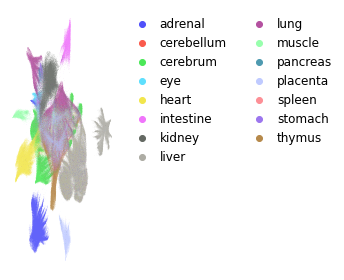

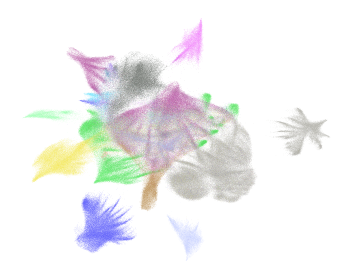

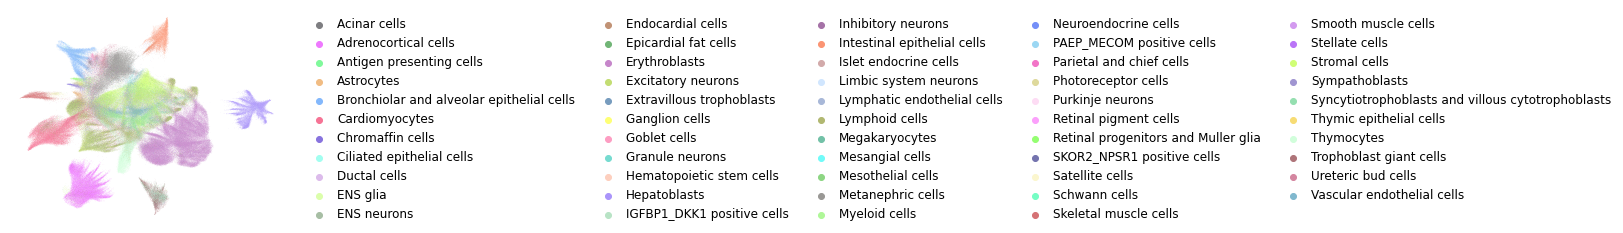

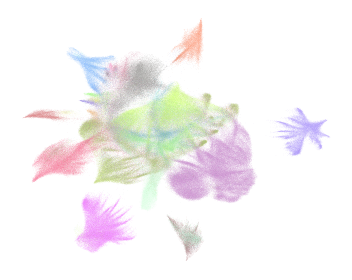

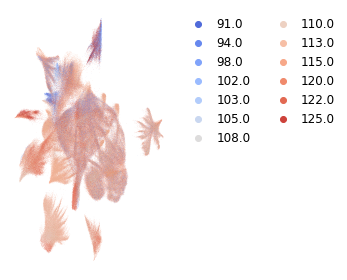

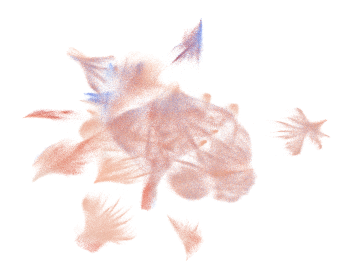

In [29]:
for c in ["tissue", "cell_type", "day_of_pregnancy_cat"]:
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    sc.pl.umap(
            atac,
            color=[c],
            ax=axs,
            show=False,
            palette=palletes[c],
            # size=100,
        )

    
    axs.set_title("")
    axs.set_axis_off()
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncols=np.ceil(len(palletes[c])/12))
    plt.savefig(
        FIG_DIR_LCL + f"atac_{c}_umap.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    sc.pl.umap(
            atac,
            color=[c],
            ax=axs,
            show=False,
            palette=palletes[c],
            # size=100,
        )

    
    axs.set_title("")
    axs.set_axis_off()
    plt.legend().remove()
    plt.savefig(
        FIG_DIR_LCL + f"atac_{c}_umap_nleg.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.tight_layout()
    plt.show()

In [30]:
atac.write(DATA_DIR_LCL + "adata_atac.h5ad")